# Ratio Put-Spread Strategy

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

#### __Defining the universe__
The entire execution pipeline is handled via the DataManager class, so we just add methods to the pipline which get executed once the pipeline is populated. Due to the volume of data to be processed, options chains are pulled in in parallel, processed and then deleted from memory. Necessary data are retained in the model and used for later inference. 

In [2]:
import options_wizard as ow

stocks = [
    "AAPL", "MSFT", "NVDA", "GOOG", "GOOGL",
    #"AMZN", "FB", "AVGO", "TSLA", "PEP",
    #"COST", "NFLX", "ADBE", "CSCO", "AMD",
    #"INTC", "LIN", "TXN", "QCOM", "AMAT"
]
for stock in stocks.copy():
    if stock not in available_ticks:
        print(f"Removing {stock} from universe - data not available")
        stocks.remove(stock)

universe = ow.Universe(stocks)
data_manager = ow.DataManager(universe, load_lazy=True)

C:\Users\cameronA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\exchange_calendars\exchange_calendar.py:2346: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


#### __Transforming the Data__
Data transformations are those which will define the dataset for a given stock, that can be then used to infer features, returns and execute strategies. These methods can filter out contracts, changing the size of the options chain dataframe. These, along with the rest of the dataset are deleted once the tick's pipeline has been executed.

In [3]:
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('scale_by_splits')
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', test_size=0.45, drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')


#### __Defining the Trade Strategy__
This defines the trade strategy for the model. It is important that the returns of the strategy are fit to the same row as the features of the strategy. Ie if you have an entry signal, the returns of the subsequent trade should be in the same column as the entry signal.

In [4]:
ow.Strategy(data_manager)('new_ratio_spread', lower_ttm=90, upper_ttm=150, delta_atm=0.45, delta_otm=0.15, otm_ratio=2)
ow.Backtest(data_manager)('multi_day_entry', hold_period=30, entry_cost_size='short', initial_capital=1_000_000.0, capital_per_trade=0.025*12/256, all_returns=True)

#### __Model prediction and Pipeline Execution__
The model pipeline execution is paralelised accross available cores, this is defaulted to at 8 due to memory issues.

In [5]:
data_manager.execute_pipeline(retain_data=True, save_data=False, n_workers=6)

#### __Result Visualisation__ 

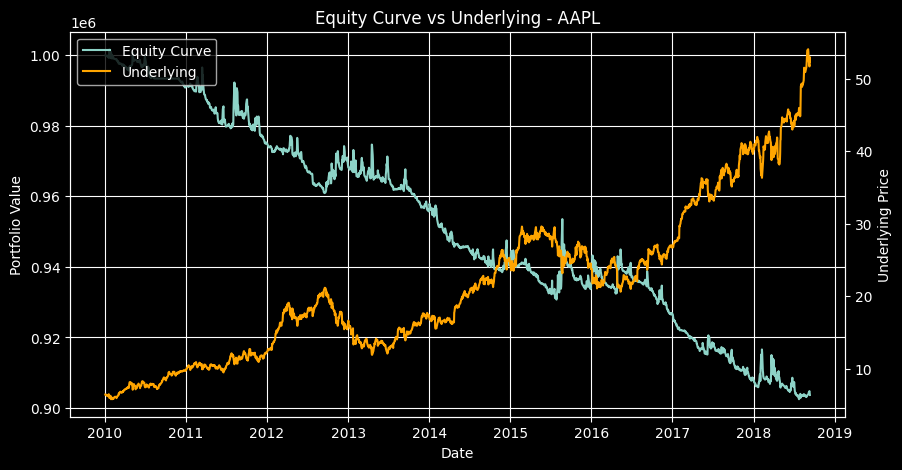

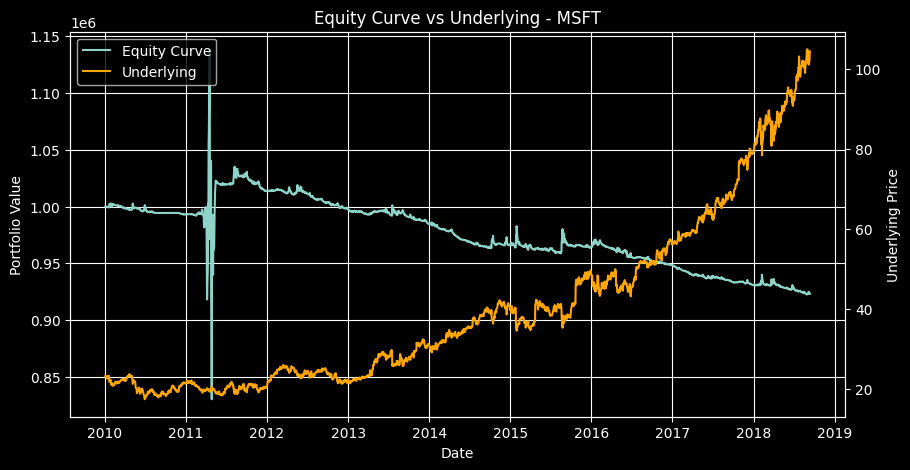

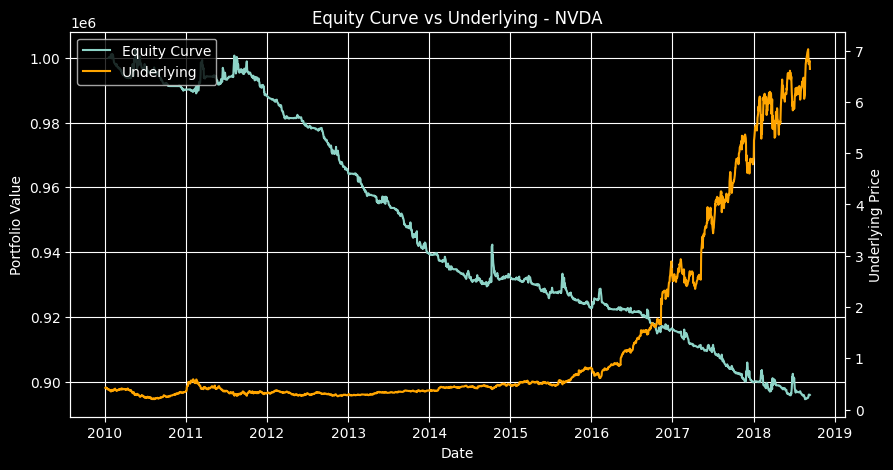

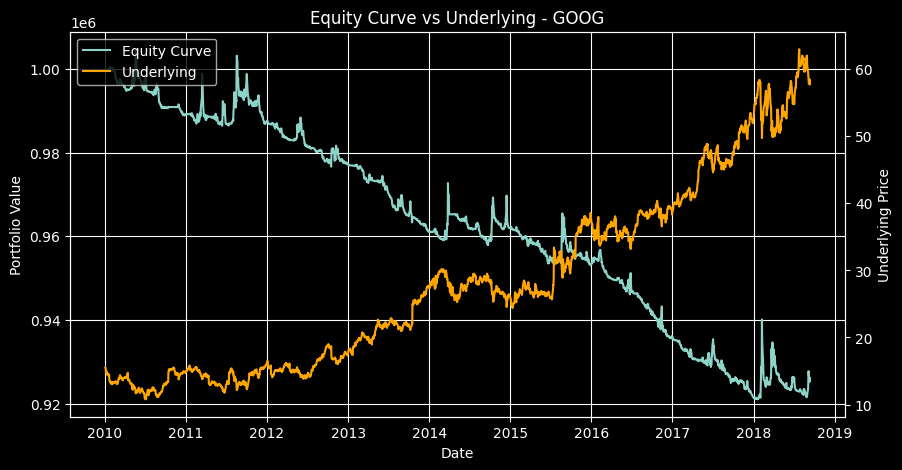

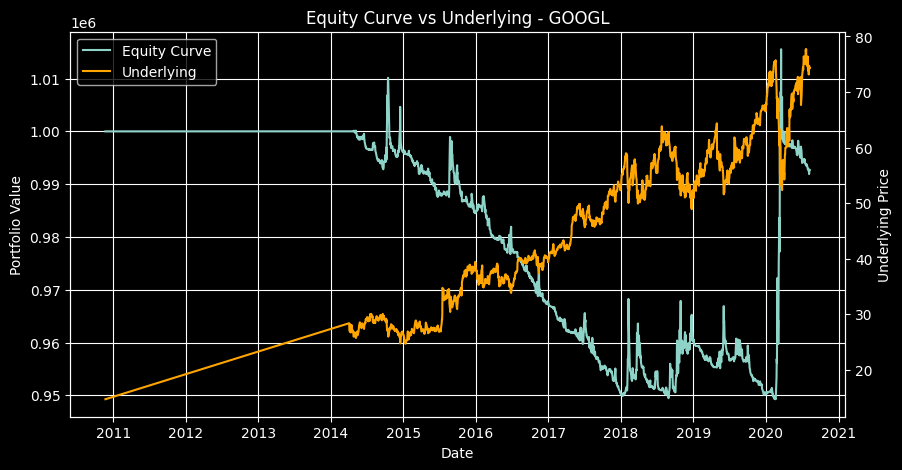

In [8]:
start = "2010-01-01"
end   = "2020-12-31"

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

for tick in universe.ticks:
    # --- Filter equity curve ---
    # --- Filter underlying ---
    underlying = data_manager.data[tick]['underlying_close']
    underlying_dates = underlying.index.get_level_values('trade_date_idx')

    mask = (underlying_dates >= start) & (underlying_dates <= end)
    underlying_slice = underlying[mask]

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(10,5))

    ax1.plot(data_manager.outputs[tick]['equity'], label="Equity Curve")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Portfolio Value")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(
        underlying_slice.index.get_level_values('trade_date_idx'),
        underlying_slice.values,
        color='orange',
        label="Underlying"
    )
    ax2.set_ylabel("Underlying Price")

    # Combined legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title(f"Equity Curve vs Underlying - {tick}")
    plt.show()
